In [1]:
"""
准备数据集：将临床医学的图片整理为不同的类别并将其划分为训练集和测试集。

加载数据集：使用Python中的图像处理库如OpenCV或Pillow加载图片，并将其转换为合适的数据格式，如numpy数组。

定义模型：使用TensorFlow或PyTorch定义深度学习模型，通常是卷积神经网络（CNN）。

训练模型：使用训练集对模型进行训练，并调整模型参数以获得更好的性能。

评估模型：使用测试集对模型进行评估，并计算其准确度、精确度和召回率等指标。

预测：使用训练好的模型对新的临床医学图片进行分类。
"""
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns

In [2]:
# 设置数据集目录和图像大小
train_dir_Normal = 'chest X-ray_images/chest_xray/train/NORMAL'
train_dir_Pneumonia = 'chest X-ray_images/chest_xray/train/PNEUMONIA/'
train_dir = 'chest X-ray_images/chest_xray/train'

test_dir_Normal = 'chest X-ray_images/chest_xray/test/NORMAL'
test_dir_Pneumonia = 'chest X-ray_images/chest_xray/test/PNEUMONIA'
test_dir = 'chest X-ray_images/chest_xray/test'

test_dir_val_Normal = 'chest X-ray_images/chest_xray/val/NORMAL'
test_dir_val_Pneumonia = 'chest X-ray_images/chest_xray/val/PNEUMONIA'
test_dir_val = 'chest X-ray_images/chest_xray/val'

img_size = (224, 224)
labels = ['NORMAL', 'PNEUMONIA']

#打印数据集中的图片数量
print('total training images:', len(os.listdir(train_dir_Normal)) + len(os.listdir(train_dir_Pneumonia)))
print('Positive training images:', len(os.listdir(train_dir_Pneumonia)))
print('Negative training images:', len(os.listdir(train_dir_Normal)))
print('total test images:', len(os.listdir(test_dir_Normal)) + len(os.listdir(test_dir_Pneumonia)))
print('Positive test images:', len(os.listdir(test_dir_Pneumonia)))
print('Negative test images:', len(os.listdir(test_dir_Normal)))
print('total val images:', len(os.listdir(test_dir_val_Normal)) + len(os.listdir(test_dir_val_Pneumonia)))
print('Positive val images:', len(os.listdir(test_dir_val_Pneumonia)))
print('Negative val images:', len(os.listdir(test_dir_val_Normal)))


total training images: 5216
Positive training images: 3875
Negative training images: 1341
total test images: 624
Positive test images: 390
Negative test images: 234
total val images: 16
Positive val images: 8
Negative val images: 8


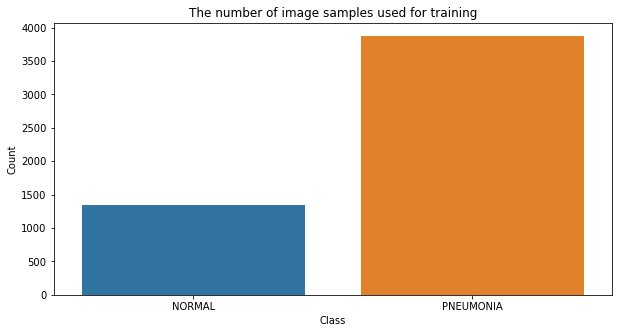

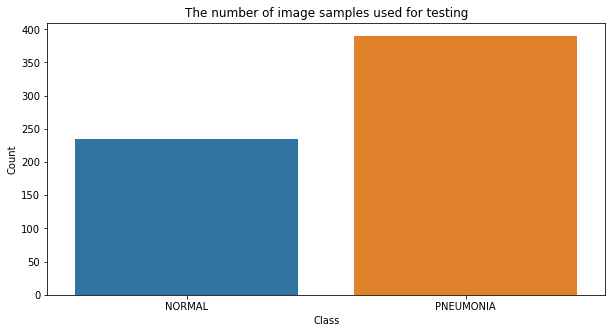

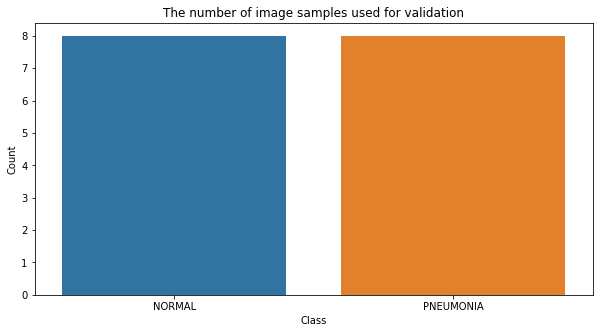

In [3]:
#Data Processing and Visualization
#将train_dir, test_dir, test_dir_val转换成柱状图
def get_data_to_bar(data_dir):
    count = []
    for img in labels:
        path = os.path.join(data_dir, img)
        count.append(len(os.listdir(path)))
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=count)
    plt.xlabel('Class')
    plt.ylabel('Count')
    #根据文件夹名，打印出对应的train/test/val标题
    if data_dir == train_dir:
        plt.title('The number of image samples used for training')
    elif data_dir == test_dir:
        plt.title('The number of image samples used for testing')
    else:
        plt.title('The number of image samples used for validation')
    plt.show()


get_data_to_bar(train_dir)
get_data_to_bar(test_dir)
get_data_to_bar(test_dir_val)

由于数据集中的图片数量不均衡，因此需要对其进行平衡

为了使数据集中的图片数量均衡，我们将使用数据增强技术(Data Augmentation technique)来增加数据集中的图片数量

Q: 为什么要对数据集进行平衡？ Ans:https://zhuanlan.zhihu.com/p/41679153

在下文对图像的处理环节中使用


In [4]:
#将train_dir_Normal和train_dir_Pneumonia的图片定义标签后随机排列在一起，并将其转换为numpy数组
img_size = 224
labels = ['NORMAL', 'PNEUMONIA']
def get_data(data_dir):
    data = []
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE表示将图片转换为灰度图
                resized_arr = cv2.resize(img_arr, (img_size,img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train_data = get_data(train_dir)
test_data = get_data(test_dir)
val_data = get_data(test_dir_val)
#print(train_data.shape)
#将train_data和train_labels打印出来
#train_data.shape = (5216, 224, 224, 3)  train_labels.shape = (5216,)  照片总数为5216张，每张照片的大小为224*224*3, 3表示RGB三个通道

<Figure size 432x288 with 0 Axes>

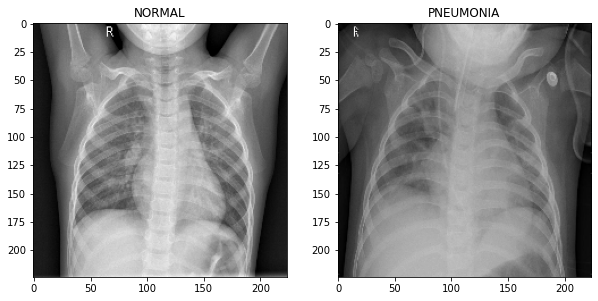

In [5]:
#打印一张NORMAL和PNEUMONIA的图片

plt.figure()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_data[0][0], cmap='gray')
plt.title('NORMAL')
plt.subplot(1, 2, 2)

plt.imshow(train_data[5215][0], cmap='gray')
plt.title('PNEUMONIA')
plt.show()

#preview_data(train_data, train_labels)
#print('ok')

对于图像的处理分析研究：

方法一：使用Keras的ImageDataGenerator()方法，对图像进行处理，包括：归一化、旋转、缩放、水平翻转、垂直翻转、剪切、缩放等

方法二：先进行灰度归一化减少光照差异导致的影响，再进行图像增强

In [6]:
x_train = []
y_train = []
x_test, y_test = [], []
x_val, y_val = [], []


for feature, label in train_data:
    x_train.append(feature) #feature是图片的数据，label是图片的标签
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)


In [7]:
#Unit 2.2.1: Data Preprocessing
#方法二：使用灰度归一化减少光照差异的影响
# 规范化数据
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

from keras.callbacks import ReduceLROnPlateau

x_train = np.array(x_train).astype('float32') / 255.0 
x_test = np.array(x_test).astype('float32') / 255.0
x_val = np.array(x_val).astype('float32') / 255.0

# resize data for deep learning
x_train = np.array(x_train).reshape(-1, 224, 224, 1) #reshape(-1, 224, 224, 1)中的-1表示不确定，224*224为图片的大小，1表示图片的通道数
y_train = np.array(y_train)

x_test = np.array(x_test).reshape(-1, 224, 224, 1)
y_test = np.array(y_test)

x_val = np.array(x_val).reshape(-1, 224, 224, 1)
y_val = np.array(y_val)

#Data Augmentation
#使用ImageDataGenerator对数据进行增强

image_datagen = ImageDataGenerator(
    rotation_range=10,        #random rotation angle
    width_shift_range=0.1,    #horizontal translation
    height_shift_range=0.1,   #vertical translation
    shear_range=0.1,          #shear strength (counterclockwise direction)
    zoom_range=0.1,           #random zoom range
    featurewise_center=False, #Whether to decentralize the input data (mean value is 0)
    samplewise_center=False,  #Whether to make each sample mean of input data 0
    featurewise_std_normalization=False, #Whether the data is standardized
    samplewise_std_normalization=False, #Whether to divide each sample data by its own standard deviation
    zca_whitening=False,      #Whether to apply ZCA whitening to the input data
    vertical_flip=False,      #whether to randomly flip vertically
)
image_datagen.fit(x_train)



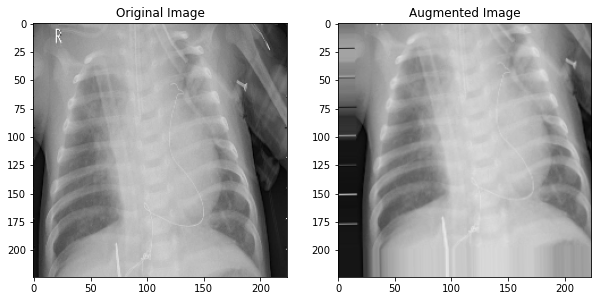

In [8]:
#Choose a random image from the x_train dataset
#随机选择一张图片打印并进行增强后打印
random_index = np.random.randint(0, len(x_train)-1)
choosed_image = x_train[random_index]

imput_img = choosed_image.reshape((1, 224, 224, 1))
proed_img = image_datagen.flow(imput_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(choosed_image.reshape(224, 224), cmap='gray')
ax[0].set_title('Original Image')


ax[1].imshow(proed_img.next().reshape(224, 224), cmap='gray')
ax[1].set_title('Augmented Image')

plt.show()

使用 ImgeDataGenerator()类 对图像进行处理的好处：
1.逐步加载；2.自动缩放图像的像素值。 

In [9]:
#Unit 2.2.2: Build a CNN Model
#使用Sequential()函数创建一个模型: 三个卷积层，两个全连接层, 一个输出层:
# Conv2D()函数创建卷积层，MaxPooling2D()函数创建池化层，
# Dropout()函数防止过拟合，Dense()函数创建全连接层，BatchNormalization()用于规范化数据

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization()) 
model.add(MaxPooling2D((2, 2), strides=2, padding = 'same'))

model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'))
model.add(Dropout(0.1)) 

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding = 'same'))

model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#卷积层到全连接层的过渡
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#compile()函数用于配置训练模型，optimizer参数用于设置训练模型的优化器，loss参数用于设置训练模型的损失函数，metrics参数用于设置训练模型的评价指标
model.summary()

y_train = np.array(y_train)
y_val = np.array(y_val)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.00001)


In [11]:
history = model.fit(image_datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=image_datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 339s 2s/step - loss: 0.7511 - accuracy: 0.8589 - val_loss: 19.5776 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 338s 2s/step - loss: 0.2190 - accuracy: 0.9208 - val_loss: 11.2952 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - 341s 2s/step - loss: 0.1859 - accuracy: 0.9310 - val_loss: 92.3962 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9448
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 344s 2s/step - loss: 0.1723 - accuracy: 0.9448 - val_loss: 3.2846 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/12
163/163 [==============================] - 352s 2s/step - loss: 0.1161 - accuracy: 0.9622 - val_loss: 0.3013 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 6/12
163/163 [==============================] 

In [12]:
print('Training Accuracy: ', history.history['accuracy'][-1])

print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test, y_test)[1]*100 , "%")

Training Accuracy:  0.9768021702766418
20/20 [==============================] - 8s 410ms/step - loss: 0.4052 - accuracy: 0.9231
Loss of the model is -  0.40515372157096863
20/20 [==============================] - 8s 405ms/step - loss: 0.4052 - accuracy: 0.9231
Accuracy of the model is -  92.30769276618958 %


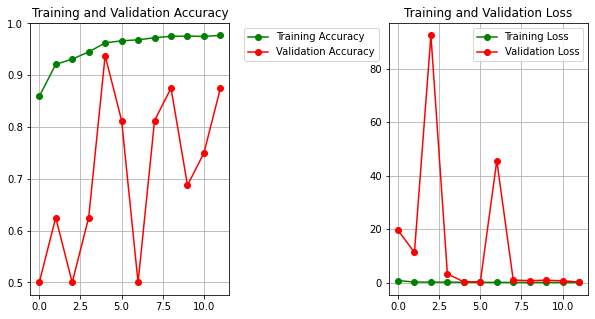

In [13]:
#Unit 2.2.3: Analysis of the model
#使用matplotlib.pyplot模块绘制训练集和验证集的准确率和损失值

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1, 2)
ax[0].plot(epochs, history.history['accuracy'], 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, history.history['val_accuracy'], 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
ax[0].grid(True)

fig.subplots_adjust(wspace=0.8)

fig.set_size_inches(10, 5)
ax[1].plot(epochs, history.history['loss'], 'go-', label = 'Training Loss')
ax[1].plot(epochs, history.history['val_loss'], 'ro-', label = 'Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].grid(True)

#折线图的意义：训练集和验证集的准确率和损失值随着训练轮数的增加而变化，训练集的准确率和损失值随着训练轮数的增加而变化。

In [14]:
#Unit2.2.4: evaluation confusion matrix
#Prediction: 使用predict()函数对测试集进行预测
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int).reshape(x_test.shape[0])

print(classification_report(y_test, y_pred,target_names=['Pneumonia(0)','Normal(0)']))

20/20 [==============================] - 8s 393ms/step
              precision    recall  f1-score   support

Pneumonia(0)       0.90      0.89      0.90       234
   Normal(0)       0.93      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624



[[208  26]
 [ 22 368]]


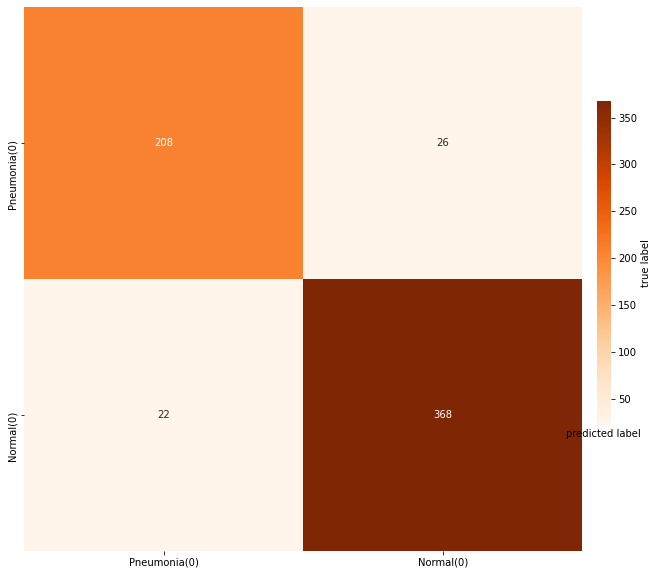

In [15]:
con_m = confusion_matrix(y_test, y_pred)
print(con_m)

con_m = pd.DataFrame(con_m, index=['Pneumonia(0)','Normal(0)'], columns=['Pneumonia(0)','Normal(0)'])
#Heatmap of confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
#热力图添加图例条cbar_ax参数用于设置图例条的位置
sns.heatmap(con_m, annot=True, fmt=".0f", ax=ax, cmap=plt.cm.Oranges, cbar_ax = plt.axes([.92, 0.3, 0.02, 0.45]))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

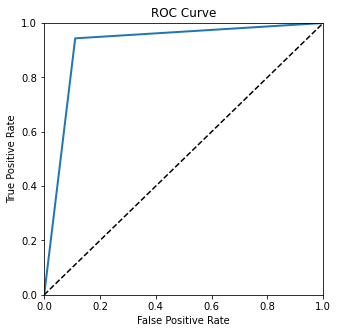

In [16]:
#Unit2.2.5: ROC curve
#ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


Correctly classified images:


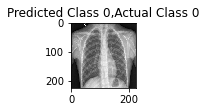

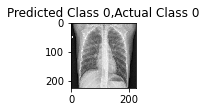

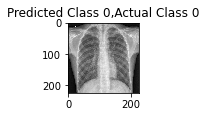

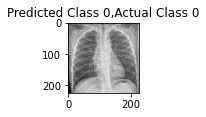

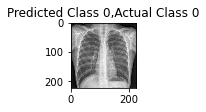

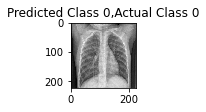

Incorrectly classified images:


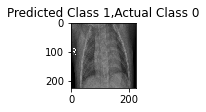

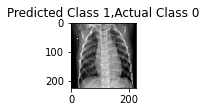

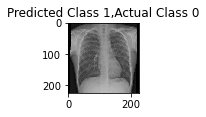

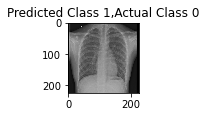

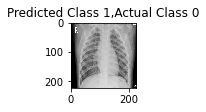

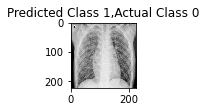

In [17]:
# Correctly/Incorrectly classified images

Correct_image = np.nonzero(y_pred == y_test)[0]
Incorrect_image = np.nonzero(y_pred != y_test)[0]

i = 0
print("Correctly classified images:")
#2x4排列
for c in Correct_image[:6]:
    
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1
    plt.show()

print("====================================")

print("Incorrectly classified images:")
i = 0
for c in Incorrect_image[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1
    plt.show()

In [50]:
#可解释性深度学习
#CAM

import torch
from torchcam.methods import CAM
from torchvision.models import resnet50
from PIL import Image
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)

model = resnet50(pretrained=True).eval().to(device)
#print('model', model)

cam_extractor = CAM(model, target_layer='layer4')

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])

img_path = 'CAM_test/person15_virus_46.jpeg'
img_pil = Image.open(img_path).convert('RGB')
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) #预处理
#print('input_tensor', input_tensor)
print('input_tensor.shape', input_tensor.shape)

pred_logits = model(input_tensor)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
print('pred_id', pred_id)


device cpu


input_tensor.shape torch.Size([1, 3, 224, 224])
pred_id 126


activation_map.shape (7, 7)


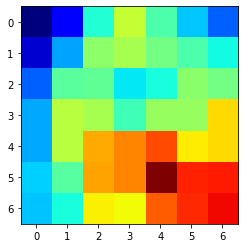

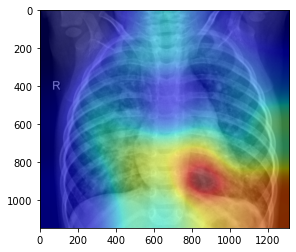

In [51]:
activation_map = cam_extractor(pred_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
print('activation_map.shape', activation_map.shape)
activation_map
plt.imshow(activation_map, cmap='jet')
plt.show()

from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(activation_map, mode='F'), alpha=0.5)
plt.imshow(result)
plt.show()